# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier

In [2]:
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# 2. Introduction

This notebook is the follow-up to the [data processing and exploring perfomed earlier](https://www.kaggle.com/epdrumond/icu-admission-data-cleaning-and-exploration). So, we are not using the raw data, but a preprocessed version. Here we are going to focus on feature selection, feature engineering and the actual development of a predictive model.

On this last point, it is interesting to reflect on how our model could be used to help identify which patients will require ICU attention. It is safe to assume the sooner we are able to identify the patients who demand extra care, the better. So, one way to tackle this problem is:

1. Create a classification model using only the first window data.

Of course, we could be discarding valuable data by following this path. However, if the models proves to be accurate enough, we would be saving the medical staff a lot of time, as well as saving many lifes.

Additionally, we can use another approach to this problem and take advantage of the time series data. We just have to remember this chronological information is not composed of a lot of different time steps, specially considering we should discard data taken after the ICU admission. Given all that, we decided to use the following approach:

2. Create a classification model using the data from the two most recent measurements for each patient.

In this work, we are going to follow these two paths and then compare the results to find out which one produces the best predictions.

In [3]:
#Load preprocessed data
file_path = '/kaggle/input/icu-admission-data-cleaning-and-exploration/'
file_name = 'first_step_output_data.csv'
data = pd.read_csv(file_path + file_name, index_col = 0)

data.head()

,AGE_ABOVE65_1,AGE_PERCENTIL_1,GENDER_1,HTN_1,PATIENT_VISIT_IDENTIFIER_1,BLOODPRESSURE_DIASTOLIC_DIFF_1,BLOODPRESSURE_DIASTOLIC_DIFF_REL_1,BLOODPRESSURE_DIASTOLIC_MAX_1,BLOODPRESSURE_DIASTOLIC_MEAN_1,BLOODPRESSURE_DIASTOLIC_MEDIAN_1,...,RESPIRATORY_RATE_MEAN_5,RESPIRATORY_RATE_MEDIAN_5,RESPIRATORY_RATE_MIN_5,TEMPERATURE_DIFF_5,TEMPERATURE_DIFF_REL_5,TEMPERATURE_MAX_5,TEMPERATURE_MEAN_5,TEMPERATURE_MEDIAN_5,TEMPERATURE_MIN_5,ICU
0,1,60th,0,0.0,0,-1.000000,-1.000000,-0.247863,0.086420,0.086420,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,0,10th,0,0.0,2,-0.547826,-0.515528,-0.435897,-0.489712,-0.506173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,0,40th,1,0.0,3,-1.000000,-1.000000,-0.299145,0.012346,0.012346,...,-0.535593,-0.517241,-0.857143,-0.047619,-0.047619,0.623188,0.033571,-0.035714,0.120879,0
4,0,10th,0,0.0,4,-1.000000,-1.000000,-0.076923,0.333333,0.333333,...,-0.499708,-0.517241,-0.500000,-0.642857,-0.645793,0.014493,0.040640,0.071429,0.208791,0
5,0,10th,0,0.0,5,-0.826087,-0.860870,-0.247863,-0.037037,-0.037037,...,-0.502825,-0.517241,-0.428571,-0.738095,-0.736640,-0.130435,-0.109127,-0.107143,0.186813,0


# 3. Model #1: Window-1 Data Only

In [4]:
#Remove all data take after window 1
model_1_cols = [x for x in data.columns if x[-1] not in [str(y) for y in range(2,6)]]
data_1 = data[model_1_cols]

data_1.head()

,AGE_ABOVE65_1,AGE_PERCENTIL_1,GENDER_1,HTN_1,PATIENT_VISIT_IDENTIFIER_1,BLOODPRESSURE_DIASTOLIC_DIFF_1,BLOODPRESSURE_DIASTOLIC_DIFF_REL_1,BLOODPRESSURE_DIASTOLIC_MAX_1,BLOODPRESSURE_DIASTOLIC_MEAN_1,BLOODPRESSURE_DIASTOLIC_MEDIAN_1,...,RESPIRATORY_RATE_MEAN_1,RESPIRATORY_RATE_MEDIAN_1,RESPIRATORY_RATE_MIN_1,TEMPERATURE_DIFF_1,TEMPERATURE_DIFF_REL_1,TEMPERATURE_MAX_1,TEMPERATURE_MEAN_1,TEMPERATURE_MEDIAN_1,TEMPERATURE_MIN_1,ICU
0,1,60th,0,0.0,0,-1.000000,-1.000000,-0.247863,0.086420,0.086420,...,-0.593220,-0.586207,-0.500000,-1.000000,-1.000000,-0.420290,-0.285714,-0.285714,0.208791,1
2,0,10th,0,0.0,2,-0.547826,-0.515528,-0.435897,-0.489712,-0.506173,...,-0.645951,-0.517241,-0.714286,-1.000000,-1.000000,0.101449,0.357143,0.357143,0.604396,1
3,0,40th,1,0.0,3,-1.000000,-1.000000,-0.299145,0.012346,0.012346,...,-0.457627,-0.448276,-0.357143,-1.000000,-1.000000,-0.420290,-0.285714,-0.285714,0.208791,0
4,0,10th,0,0.0,4,-1.000000,-1.000000,-0.076923,0.333333,0.333333,...,-0.593220,-0.586207,-0.571429,-0.952381,-0.953536,0.072464,0.285714,0.285714,0.538462,0
5,0,10th,0,0.0,5,-0.826087,-0.860870,-0.247863,-0.037037,-0.037037,...,-0.525424,-0.517241,-0.428571,-0.976190,-0.975891,-0.333333,-0.196429,-0.196429,0.252747,0


At this point, most data cleaning has already been performed. We have also looked at the features individually. Let's now focus on investigating the relationships between features and the target. First, we are going to look at how they correlate to each other.

## 3.1. Correlations

<Figure size 720x576 with 0 Axes>

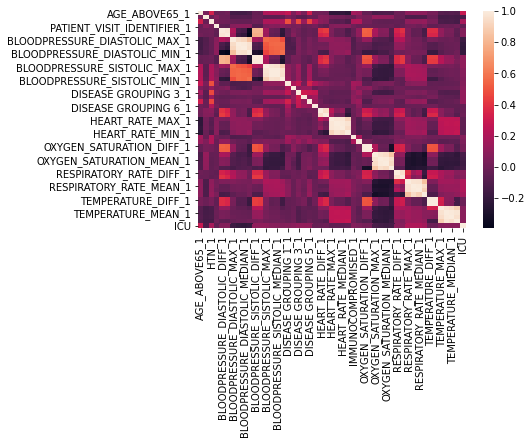

<Figure size 720x576 with 0 Axes>

In [5]:
#Compute Pearson correlation
data_1_corr = data_1.corr()

sns.heatmap(data_1_corr)
plt.figure(figsize = (10, 8))

It is very easy to see this graphical approach is not very helpful for this amount of features. So let's split our analysis in two. First we are looking at how these features relate to each other, excluding the target column.

In [6]:
#Show correlation values in stacked format
def rank_correlation_score(data):
    
    #Stack correlation map into 3-columns format
    stacked_corr = data.corr().stack().reset_index().rename(
       columns = {'level_0': 'Feature_1',
                  'level_1': 'Feature_2',
                  0: 'Pearson_Corr'})
    
    #Remove redudant relationships
    stacked_corr = stacked_corr.query('Feature_1 != Feature_2')
    chained_feature_names = ['-'.join(np.sort(x)) for x in stacked_corr[['Feature_1', 'Feature_2']].values]
    stacked_corr.loc[:,'Duplicate_Key'] = chained_feature_names
    stacked_corr = stacked_corr.drop_duplicates(subset = 'Duplicate_Key').drop(columns = 'Duplicate_Key')

    #Remove correlations to the target
    stacked_corr = stacked_corr[stacked_corr['Feature_1'] != 'ICU']
    stacked_corr = stacked_corr[stacked_corr['Feature_2'] != 'ICU']
    
    # Order absolute correlation strenght
    stacked_corr['Pearson_Corr'] = abs(stacked_corr['Pearson_Corr'])
    return stacked_corr.sort_values(by = 'Pearson_Corr', ascending = False)

stacked_data_1_corr = rank_correlation_score(data_1)
stacked_data_1_corr

,Feature_1,Feature_2,Pearson_Corr
2101,TEMPERATURE_DIFF_1,TEMPERATURE_DIFF_REL_1,0.999444
1501,OXYGEN_SATURATION_DIFF_1,OXYGEN_SATURATION_DIFF_REL_1,0.998889
651,BLOODPRESSURE_SISTOLIC_MEAN_1,BLOODPRESSURE_SISTOLIC_MEDIAN_1,0.996952
1251,HEART_RATE_MEAN_1,HEART_RATE_MEDIAN_1,0.993374
2251,TEMPERATURE_MEAN_1,TEMPERATURE_MEDIAN_1,0.993236
...,...,...,...
733,BLOODPRESSURE_SISTOLIC_MEDIAN_1,TEMPERATURE_MIN_1,0.000809
924,DISEASE GROUPING 3_1,TEMPERATURE_DIFF_1,0.000746
516,BLOODPRESSURE_SISTOLIC_DIFF_1,HEART_RATE_MEDIAN_1,0.000576
194,PATIENT_VISIT_IDENTIFIER_1,TEMPERATURE_MIN_1,0.000536


As we can see, some feature present quite the correlation coefficient. Let's take a closer look at the ones in which the *Pearson_Corr* is larger than 0.99.

In [7]:
#Filter very strong correlations
stacked_data_1_corr[stacked_data_1_corr['Pearson_Corr'] > 0.99]

,Feature_1,Feature_2,Pearson_Corr
2101,TEMPERATURE_DIFF_1,TEMPERATURE_DIFF_REL_1,0.999444
1501,OXYGEN_SATURATION_DIFF_1,OXYGEN_SATURATION_DIFF_REL_1,0.998889
651,BLOODPRESSURE_SISTOLIC_MEAN_1,BLOODPRESSURE_SISTOLIC_MEDIAN_1,0.996952
1251,HEART_RATE_MEAN_1,HEART_RATE_MEDIAN_1,0.993374
2251,TEMPERATURE_MEAN_1,TEMPERATURE_MEDIAN_1,0.993236
351,BLOODPRESSURE_DIASTOLIC_MEAN_1,BLOODPRESSURE_DIASTOLIC_MEDIAN_1,0.992260
1651,OXYGEN_SATURATION_MEAN_1,OXYGEN_SATURATION_MEDIAN_1,0.990731
501,BLOODPRESSURE_SISTOLIC_DIFF_1,BLOODPRESSURE_SISTOLIC_DIFF_REL_1,0.990595


What we see here is that there are two measurement combinations which tend to present a strong correlation between each other. They are:

* MEAN/MEDIAN.
* DIFF/DIFF_REL

Well, it is exactly surprising to see this behavior. Still, it is better have proof than to base our feature selecion in assumptions. We are going even deeper and try to see if this assessment is true in every case for out dataset. 

In [8]:
#Investigate MEAN/MEDIAN correlations
stacked_data_1_corr['MEASURE_FEATURE_1'] = [x.split('_')[0] for x in stacked_data_1_corr['Feature_1']]
stacked_data_1_corr['MEASURE_FEATURE_2'] = [x.split('_')[0] for x in stacked_data_1_corr['Feature_2']]
stacked_data_1_corr['TYPE_FEATURE_1'] = [x.split('_')[-2] for x in stacked_data_1_corr['Feature_1']]
stacked_data_1_corr['TYPE_FEATURE_2'] = [x.split('_')[-2] for x in stacked_data_1_corr['Feature_2']]

mean_median_corr = stacked_data_1_corr.query('MEASURE_FEATURE_1 == MEASURE_FEATURE_2')
mean_median_corr = mean_median_corr.query('TYPE_FEATURE_1 != TYPE_FEATURE_2')
mean_median_corr = mean_median_corr[mean_median_corr['TYPE_FEATURE_1'].isin(['MEDIAN', 'MEAN'])]
mean_median_corr = mean_median_corr[mean_median_corr['TYPE_FEATURE_2'].isin(['MEDIAN', 'MEAN'])]

relevant_cols = ['Feature_1', 'Feature_2', 'Pearson_Corr']
mean_median_corr[relevant_cols]

,Feature_1,Feature_2,Pearson_Corr
651,BLOODPRESSURE_SISTOLIC_MEAN_1,BLOODPRESSURE_SISTOLIC_MEDIAN_1,0.996952
1251,HEART_RATE_MEAN_1,HEART_RATE_MEDIAN_1,0.993374
2251,TEMPERATURE_MEAN_1,TEMPERATURE_MEDIAN_1,0.993236
351,BLOODPRESSURE_DIASTOLIC_MEAN_1,BLOODPRESSURE_DIASTOLIC_MEDIAN_1,0.992260
1651,OXYGEN_SATURATION_MEAN_1,OXYGEN_SATURATION_MEDIAN_1,0.990731
1951,RESPIRATORY_RATE_MEAN_1,RESPIRATORY_RATE_MEDIAN_1,0.989124
357,BLOODPRESSURE_DIASTOLIC_MEAN_1,BLOODPRESSURE_SISTOLIC_MEDIAN_1,0.560540
405,BLOODPRESSURE_DIASTOLIC_MEDIAN_1,BLOODPRESSURE_SISTOLIC_MEAN_1,0.539823


Well, the table shows there are no exceptions to our previous assertion. Still, there are two smaller correlations values above. If you look closer, however, *Feature_1* and *Feature_2* are not part of the same measurement. They probably just slipped through our filters and don't matter for this specific step.

In the end, this means we do not need both *MEAN* and *MEDIAN* features for a given measurement type. So, we are going to stick with the *MEAN* attributes for now.

In [9]:
#List columns to be removed
cols_to_remove = ['BLOODPRESSURE_DIASTOLIC_MEDIAN_1', 'BLOODPRESSURE_SISTOLIC_MEDIAN_1', 'HEART_RATE_MEDIAN_1',
                  'OXYGEN_SATURATION_MEDIAN_1', 'RESPIRATORY_RATE_MEDIAN_1', 'TEMPERATURE_MEDIAN_1']

In [10]:
#Investigate DIFF/DIFF_REL correlations
diff_corr = stacked_data_1_corr.query('MEASURE_FEATURE_1 == MEASURE_FEATURE_2')
diff_corr = diff_corr.query('TYPE_FEATURE_1 != TYPE_FEATURE_2')
diff_corr = diff_corr[diff_corr['TYPE_FEATURE_1'].isin(['DIFF', 'REL'])]
diff_corr = diff_corr[diff_corr['TYPE_FEATURE_2'].isin(['DIFF', 'REL'])]

diff_corr[relevant_cols]

,Feature_1,Feature_2,Pearson_Corr
2101,TEMPERATURE_DIFF_1,TEMPERATURE_DIFF_REL_1,0.999444
1501,OXYGEN_SATURATION_DIFF_1,OXYGEN_SATURATION_DIFF_REL_1,0.998889
501,BLOODPRESSURE_SISTOLIC_DIFF_1,BLOODPRESSURE_SISTOLIC_DIFF_REL_1,0.990595
201,BLOODPRESSURE_DIASTOLIC_DIFF_1,BLOODPRESSURE_DIASTOLIC_DIFF_REL_1,0.978508
1801,RESPIRATORY_RATE_DIFF_1,RESPIRATORY_RATE_DIFF_REL_1,0.961739
1101,HEART_RATE_DIFF_1,HEART_RATE_DIFF_REL_1,0.949914
207,BLOODPRESSURE_DIASTOLIC_DIFF_1,BLOODPRESSURE_SISTOLIC_DIFF_REL_1,0.799433
255,BLOODPRESSURE_DIASTOLIC_DIFF_REL_1,BLOODPRESSURE_SISTOLIC_DIFF_1,0.777548


Once again, no exceptions are found for the *DIFF/DIFF_REL* correlation behavior. As in the previous table, the second and third records are to be neglected, since they are not actually comparing the same measurement type. For this duo, we choose the *DIFF_REL* features to remove.

In [11]:
#Add columns to the remove list
cols_to_remove.extend(['BLOODPRESSURE_DIASTOLIC_DIFF_REL_1', 'BLOODPRESSURE_SISTOLIC_DIFF_REL_1', 
                       'HEART_RATE_DIFF_REL_1', 'OXYGEN_SATURATION_DIFF_REL_1', 'RESPIRATORY_RATE_DIFF_REL_1',
                       'TEMPERATURE_DIFF_REL_1'])

Now that we have already evaluated the most extreme correlation cases between features, let's see how these attributes relate to the target column.

In [12]:
#Sort absolute correlations values to the target
data_1 = data_1.drop(columns = cols_to_remove)
data_1_target_corr = abs(data_1.corr()['ICU'])

data_1_target_corr[data_1_target_corr < 1].sort_values(ascending = False)

AGE_ABOVE65_1                     0.291010
RESPIRATORY_RATE_MAX_1            0.213938
RESPIRATORY_RATE_MEAN_1           0.207911
BLOODPRESSURE_DIASTOLIC_MEAN_1    0.201210
BLOODPRESSURE_DIASTOLIC_MIN_1     0.195703
HTN_1                             0.180555
RESPIRATORY_RATE_MIN_1            0.173043
BLOODPRESSURE_DIASTOLIC_MAX_1     0.166832
OXYGEN_SATURATION_MEAN_1          0.147612
OXYGEN_SATURATION_MIN_1           0.139034
OXYGEN_SATURATION_MAX_1           0.131615
DISEASE GROUPING 3_1              0.122514
DISEASE GROUPING 5_1              0.122200
GENDER_1                          0.117938
DISEASE GROUPING 4_1              0.112573
BLOODPRESSURE_SISTOLIC_MAX_1      0.109073
BLOODPRESSURE_SISTOLIC_DIFF_1     0.107106
RESPIRATORY_RATE_DIFF_1           0.093877
DISEASE GROUPING 2_1              0.087753
TEMPERATURE_MEAN_1                0.086764
TEMPERATURE_MIN_1                 0.086575
BLOODPRESSURE_SISTOLIC_MEAN_1     0.084371
TEMPERATURE_MAX_1                 0.079548
DISEASE GRO

This data does not provide us with a lot. However there's some observations we can make. First of all, the most strognly correlated feature, *AGE_ABOVE65_1*, confirms the elderly are more affected by the desease. Following, looking at the *DIFF* attributes, they are mostly positioned at weaker correlated half of our features. This is not actually a surprise considering how poorly distributed they are.

## 3.2. Feature Encoding

Looking at our data, there is still a single featute that requires some processing: *AGE_PERCENTIL_1*. Let's encoded right now and move on.

In [13]:
data_1.head()

,AGE_ABOVE65_1,AGE_PERCENTIL_1,GENDER_1,HTN_1,PATIENT_VISIT_IDENTIFIER_1,BLOODPRESSURE_DIASTOLIC_DIFF_1,BLOODPRESSURE_DIASTOLIC_MAX_1,BLOODPRESSURE_DIASTOLIC_MEAN_1,BLOODPRESSURE_DIASTOLIC_MIN_1,BLOODPRESSURE_SISTOLIC_DIFF_1,...,OXYGEN_SATURATION_MIN_1,RESPIRATORY_RATE_DIFF_1,RESPIRATORY_RATE_MAX_1,RESPIRATORY_RATE_MEAN_1,RESPIRATORY_RATE_MIN_1,TEMPERATURE_DIFF_1,TEMPERATURE_MAX_1,TEMPERATURE_MEAN_1,TEMPERATURE_MIN_1,ICU
0,1,60th,0,0.0,0,-1.000000,-0.247863,0.086420,0.237113,-1.000000,...,0.898990,-1.000000,-0.636364,-0.593220,-0.500000,-1.000000,-0.420290,-0.285714,0.208791,1
2,0,10th,0,0.0,2,-0.547826,-0.435897,-0.489712,-0.525773,-0.533742,...,0.959596,-0.764706,-0.575758,-0.645951,-0.714286,-1.000000,0.101449,0.357143,0.604396,1
3,0,40th,1,0.0,3,-1.000000,-0.299145,0.012346,0.175258,-1.000000,...,0.878788,-1.000000,-0.515152,-0.457627,-0.357143,-1.000000,-0.420290,-0.285714,0.208791,0
4,0,10th,0,0.0,4,-1.000000,-0.076923,0.333333,0.443299,-0.877301,...,0.939394,-0.882353,-0.575758,-0.593220,-0.571429,-0.952381,0.072464,0.285714,0.538462,0
5,0,10th,0,0.0,5,-0.826087,-0.247863,-0.037037,0.030928,-0.754601,...,0.919192,-1.000000,-0.575758,-0.525424,-0.428571,-0.976190,-0.333333,-0.196429,0.252747,0


In [14]:
#Define function to encode features
def encode_feature(data, col):
    new_cols = pd.get_dummies(data[col], prefix = col, prefix_sep = ':', drop_first = True)
    return pd.concat([data.drop(columns = col), new_cols], axis = 1)

In [15]:
#Encode AGE_PERCENTIL_1
data_1 = encode_feature(data_1, 'AGE_PERCENTIL_1')

## 3.3. First Attempt

We have already performed some feature selection, and before we go any further, it could be wise to see how a model performs in our data as for this point. Since our dataset is not very large, and there are not that many features remaining, this can work as a baseline model. Afterwards, we can see if removing or engineering features can maintain or even improve from this first try.

We this first attemp, let's try and use a K Nearest Neighbors classification algorithm. Our choice is based on the fact the model could be somewhat easy to interpret. 

In [16]:
#Split data into train/test and validation
np.random.seed(10)

target_col = 'ICU'
feature_cols = data_1.drop(columns = ['ICU', 'PATIENT_VISIT_IDENTIFIER_1']).columns.values

x_train, x_validation, y_train, y_validation = train_test_split(data_1[feature_cols], data_1[target_col],
                                                                test_size = 0.1)

In [17]:
#Define function to test algorithm
def score_model(estimator, train_data, validation_data, cv):
    #Unpack data
    x_train, y_train = train_data
    x_validation, y_validation = validation_data
    
    #Perfomed cross-validation on train data
    model_cv = cross_validate(estimator = estimator, X = x_train, y = y_train,
                              scoring = ['accuracy', 'roc_auc'],
                              cv = cv)
    
    #Apply model to validation data
    estimator.fit(x_train, y_train)
    y_pred = estimator.predict(x_validation)

    #Print results
    print('CV model accuracy:  %.3f +/- %.3f'  %(model_cv['test_accuracy'].mean(), 
                                              model_cv['test_accuracy'].std()))
    print('CV model roc_auc:  %.3f +/- %.3f'  %(model_cv['test_roc_auc'].mean(), 
                                             model_cv['test_roc_auc'].std()))
    print('Validation accuracy score: %.3f' %accuracy_score(y_validation, y_pred))
    print('Validation ROC_AUC score: %.3f' %roc_auc_score(y_validation, y_pred))
    
    return estimator

In [18]:
#Test KNN model
baseline_model_1 = KNN(n_neighbors = 10, weights = 'distance')
fitted_baseline_model_1 = score_model(estimator = baseline_model_1, 
                                      train_data = (x_train, y_train),
                                      validation_data = (x_validation, y_validation),
                                      cv = 10)

CV model accuracy:  0.649 +/- 0.052
CV model roc_auc:  0.686 +/- 0.086
Validation accuracy score: 0.694
Validation ROC_AUC score: 0.675


Simply put, the results are not impressive, specially considering the frequency of true values in our target is around 46%. Before we make any important decision, however, let's see how another algorithm performs on this data.

In [19]:
#Test RandomForestClassifier model
baseline_model_2 = RandomForestClassifier()
fitted_baseline_model_2 = score_model(estimator = baseline_model_2, 
                                      train_data = (x_train, y_train),
                                      validation_data = (x_validation, y_validation),
                                      cv = 10)

CV model accuracy:  0.652 +/- 0.104
CV model roc_auc:  0.723 +/- 0.087
Validation accuracy score: 0.750
Validation ROC_AUC score: 0.744


The results are now much better than before. This is a relief, considering our first model was not much better than simply randomly selecting which patients would go to the ICU. From here, there are several paths we can take:

* Further investigate the dataset in order to remove or add features;
* Tune the algorithm hyperparameters to see if we can achieve some accuracy improvement;
* Discard this approach and proceed to a time-relevant model.

For now, the better course of action seems to be keep investigating our window-1 dataset. The first thing we can do is to look at the feature importances from the Random Forest model.

## 3.4. Feature Selection

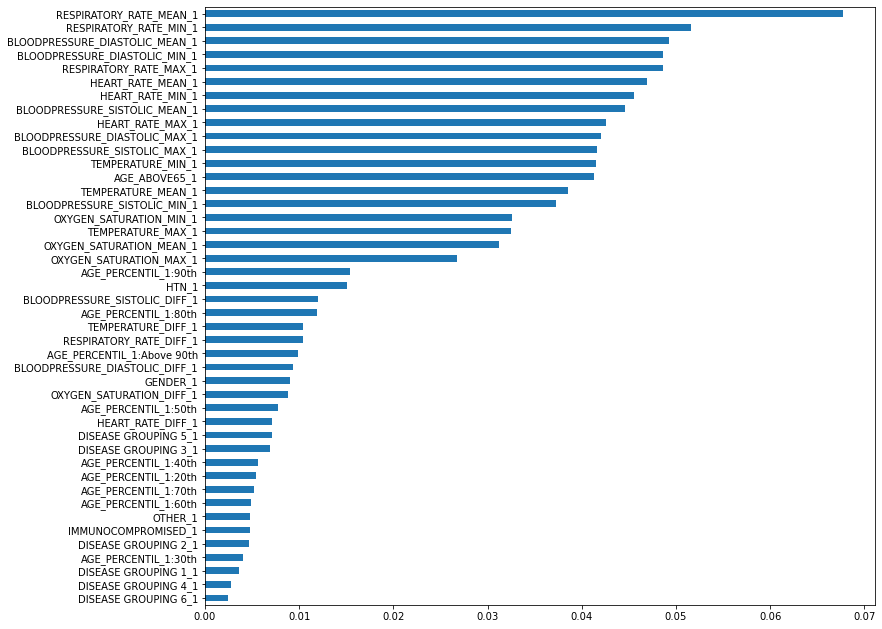

In [20]:
#Plot feature importances for the Random Forest Model
feat_importances = pd.Series(data = fitted_baseline_model_2.feature_importances_,
                             index = feature_cols).sort_values()
feat_importances.plot(kind = 'barh', figsize = (12, 11))

The graph above leads to two observations:

1. *RESPIRATORY_RATE_MEAN_1* is by far the most important feature on the classification model.
2. After *OXYGEN_SATURATION_MAX_1*, there is a significant dip on how important the attributes are for the algorithm.

One way of checking whether this assessment has any validity is to remove the least important feature from our dataset and see how the same algorithm behaves.

In [21]:
#Test RandomForest model for reduced dataset
ncols_to_keep = int(0.8 * len(feat_importances))
reduced_feat_columns = feat_importances.nlargest(n = ncols_to_keep).index

reduced_x_train = x_train[reduced_feat_columns]
reduced_x_validation = x_validation[reduced_feat_columns]

fitted_baseline_model_3 = score_model(estimator = baseline_model_2, 
                                      train_data = (reduced_x_train, y_train),
                                      validation_data = (reduced_x_validation, y_validation),
                                      cv = 10)AGE_PERCENTIL_1                        object

SyntaxError: invalid syntax (<ipython-input-21-055d542cf472>, line 11)

Comparing theses results to the ones shown above for the entire dataset version of the model, it is hard to draw conclusions. In one hand, the cross-validation results do not present a relevant change. However, the validation resuts are clearly better.

On the context of a Kaggle competition, this might be enough for us to go forward and discard these features. Still, the data is not conclusive to the point where this is a no brainer. Then, we are keeping all the attributes for now.

If we still want to explore the possibility of reducing the amount of features in our dataset, a reasonable approach is to apply a Recursive Feature Selection method. It should not take some much time, since the dataset is small. To further reduce processing time issues, we can use a simplified version of the Random Forest algorithm.

In [22]:
#Get RFE feature ranking and compare to RandomForestClassifier feature importance
rfe_model = RandomForestClassifier(n_estimators = 10)
feature_selector = RFE(estimator = rfe_model, step = 1)
feature_selector.fit(x_train, y_train)
feature_ranking = pd.Series(data = feature_selector.ranking_, index = feature_cols).sort_values()

importance_scale = pd.concat([feature_ranking, feat_importances.rank(ascending = False)], axis = 1)
importance_scale = importance_scale.rename(columns = {0: 'RFE_ranking', 1: 'RFC_ranking'})
importance_scale.sort_values(by = ['RFE_ranking', 'RFC_ranking'])

,RFE_ranking,RFC_ranking
RESPIRATORY_RATE_MEAN_1,1,1.0
RESPIRATORY_RATE_MIN_1,1,2.0
BLOODPRESSURE_DIASTOLIC_MEAN_1,1,3.0
BLOODPRESSURE_DIASTOLIC_MIN_1,1,4.0
RESPIRATORY_RATE_MAX_1,1,5.0
HEART_RATE_MEAN_1,1,6.0
HEART_RATE_MIN_1,1,7.0
BLOODPRESSURE_SISTOLIC_MEAN_1,1,8.0
HEART_RATE_MAX_1,1,9.0
BLOODPRESSURE_DIASTOLIC_MAX_1,1,10.0


Looking at both rankings, it is clear both feature selection approaches present some resemblence. This is not necessarily a godd thing, since our results on removing the least important features were not conclusive. Not let's try and see how the classification model performs if we use only the better half of the features according to the RFE algorithm.

In [23]:
#Test RandomForest model for RFE reduced dataset
cols_to_keep = importance_scale[importance_scale['RFE_ranking'] == 1].index
reduced_x_train = x_train[cols_to_keep]
reduced_x_validation = x_validation[cols_to_keep]

fitted_baseline_model_4 = score_model(estimator = baseline_model_2, 
                                      train_data = (reduced_x_train, y_train),
                                      validation_data = (reduced_x_validation, y_validation),
                                      cv = 10)

CV model accuracy:  0.664 +/- 0.057
CV model roc_auc:  0.712 +/- 0.093
Validation accuracy score: 0.778
Validation ROC_AUC score: 0.781


Again, the results appear to be slightly better then the whole-dataset model. Also again, the margin is not big enough for us to make any bold statements. 

For now, this is where we stop in terms of feature selection. The two tests we performed did provide us with conclusive results. Additionally, we are not dealing with a enormous amount of attributes, specially considering how these attributes are derived from a few measurements. The next step, then, is to see how much we are able to improve accuracy by tuning the hyperparameters.

## 3.5. Hyperparameters Tuning

So far, the best model we have produced has derived from the Random Forest algorithm. This way, we are only going to spend time tuning its hyperparemeters. In order to reduce the time we are going to spend on this procedure, only a portion of the hyperparameter is going to be investigated. They are:

* n_estimators
* criterion
* max_depth
* max_features

As our dataset is very small, it is feasable to perform a grid search for the best set of hyperparameters.

In [24]:
#Define hyperparameter space
hyper_space = {
    'n_estimators': [10, 100, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, None],
    'max_features': ['sqrt', 'log2', None]
}

In [25]:
#Perform hyperparameter tuning by grid searching the defined space
grid_search = GridSearchCV(estimator = baseline_model_2, 
                           param_grid = hyper_space,
                           scoring = 'roc_auc',
                           cv = 10,
                           n_jobs = 4,
                           verbose = 1)
grid_search_results = grid_search.fit(x_train, y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   31.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:  2.3min finished


In [26]:
#Look at the best performing set of hyperparameters and apply estimator on validation data
print(grid_search.best_params_)

best_gridsearch_model = grid_search.best_estimator_
best_gridsearch_model.fit(x_train, y_train)
y_pred = best_gridsearch_model.predict(x_validation)

print('Validation accuracy: %.3f' %(accuracy_score(y_validation, y_pred)))
print('Validation ROC_AUC: %.3f' %(roc_auc_score(y_validation, y_pred)))

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 500}
Validation accuracy: 0.778
Validation ROC_AUC: 0.769


This is by far the best results we have so far. Just by tuning the algorithm parameters we were able to improve the validation accuracy roughly by 6 percentage points. On top of that, we have reached a point in which our model should be able to correctly predict patients that are going to demand an ICU bed in over 80% of the cases.

# 4. Model #2: Classification from Last Two Available Window Data 

Now we proceed into our second approach at trying to accurately determine which patients are going to the ICU. The idea is to take advantage of the time series aspect of the dataset. 

Suppose a couple of ICU beds just became vacant (hopefully because their former occupants got better), and the medical staff wants to determine which of the current patients is more likely to take these spots. In this scenario, it would be wise to look at the most recent available data to do the assessment. However, if we are able see how these patients have progressed to their current state, a better decision could be made.

Given this rational, our idea is to use the data from the last 2 available time windows to predict ICU admission.

In [27]:
data.head()

,AGE_ABOVE65_1,AGE_PERCENTIL_1,GENDER_1,HTN_1,PATIENT_VISIT_IDENTIFIER_1,BLOODPRESSURE_DIASTOLIC_DIFF_1,BLOODPRESSURE_DIASTOLIC_DIFF_REL_1,BLOODPRESSURE_DIASTOLIC_MAX_1,BLOODPRESSURE_DIASTOLIC_MEAN_1,BLOODPRESSURE_DIASTOLIC_MEDIAN_1,...,RESPIRATORY_RATE_MEAN_5,RESPIRATORY_RATE_MEDIAN_5,RESPIRATORY_RATE_MIN_5,TEMPERATURE_DIFF_5,TEMPERATURE_DIFF_REL_5,TEMPERATURE_MAX_5,TEMPERATURE_MEAN_5,TEMPERATURE_MEDIAN_5,TEMPERATURE_MIN_5,ICU
0,1,60th,0,0.0,0,-1.000000,-1.000000,-0.247863,0.086420,0.086420,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,0,10th,0,0.0,2,-0.547826,-0.515528,-0.435897,-0.489712,-0.506173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,0,40th,1,0.0,3,-1.000000,-1.000000,-0.299145,0.012346,0.012346,...,-0.535593,-0.517241,-0.857143,-0.047619,-0.047619,0.623188,0.033571,-0.035714,0.120879,0
4,0,10th,0,0.0,4,-1.000000,-1.000000,-0.076923,0.333333,0.333333,...,-0.499708,-0.517241,-0.500000,-0.642857,-0.645793,0.014493,0.040640,0.071429,0.208791,0
5,0,10th,0,0.0,5,-0.826087,-0.860870,-0.247863,-0.037037,-0.037037,...,-0.502825,-0.517241,-0.428571,-0.738095,-0.736640,-0.130435,-0.109127,-0.107143,0.186813,0


## 4.1. Preprocess Data

Looking back at our original data, we must remember that some features do not present a time aspect, such as age and gender related attributes. These columns will be part of our final dataset, and no work is required on them at this point. The other features are the ones we are focusing on right now.

In [28]:
#Split features into time variant and time constant
features_df = pd.DataFrame(data = data.columns.values, columns = ['Feature_name'])
features_df['Feature_group'] = [x[:-2] for x in features_df['Feature_name']]

features_df = features_df.join(on = 'Feature_group',
                               other = features_df.groupby(by = 'Feature_group').count(),
                               how = 'inner',
                               rsuffix = '_count')

time_constant_features = features_df[features_df['Feature_name_count'] == 1]['Feature_name'].values
time_variant_features = [x for x in features_df['Feature_name'] if x not in time_constant_features]

time_constant_features = time_constant_features[time_constant_features != 'PATIENT_VISIT_IDENTIFIER_1']

In [29]:
#Define function to retrieve the two most recent time windows data
def last_two_windows_data(data, cols, reference_col):
    
    #Remove all records where there's only window-1 data available
    reference_group = np.sort([x for x in cols if x[:-2] == reference_col[:-2]])
    temp_data = data[data[reference_group[1]].isnull() == False].drop(columns = 'PATIENT_VISIT_IDENTIFIER_1')
    
    #Identify last two windows for each records
    reference_df = temp_data[reference_group]
    last_window = [len(reference_group) - x for x in reference_df.isnull().sum(axis = 1)]
    last_window = [[x, y] for x, y in zip(reference_df.index, last_window)]
    
    df_list = []
    #Extract desired columns for each record
    for window in range(2,6):
        index_portion = [x[0] for x in last_window if x[1] == window]
        data_portion = temp_data[temp_data.index.isin(index_portion)]
        
        window_cols = [x for x in data_portion.columns if x[-1] in [str(window), str(window - 1)]]
        data_portion = data_portion[window_cols]
        
        new_col_names = {x: x[:-1] + 'end' if x[-1] == str(window) else x[:-1] + 'begin' 
                         for x in data_portion.columns}
        
        df_list.append(data_portion.rename(columns = new_col_names))
        
    return pd.concat(df_list), last_window

In [30]:
#Get time variant features for the last two available time windows
data_2, last_window = last_two_windows_data(data = data.drop(columns = time_constant_features), 
                                            cols = time_variant_features, 
                                            reference_col = 'TEMPERATURE_MAX_1')

data_2.head()

,BLOODPRESSURE_DIASTOLIC_DIFF_begin,BLOODPRESSURE_DIASTOLIC_DIFF_REL_begin,BLOODPRESSURE_DIASTOLIC_MAX_begin,BLOODPRESSURE_DIASTOLIC_MEAN_begin,BLOODPRESSURE_DIASTOLIC_MEDIAN_begin,BLOODPRESSURE_DIASTOLIC_MIN_begin,BLOODPRESSURE_SISTOLIC_DIFF_begin,BLOODPRESSURE_SISTOLIC_DIFF_REL_begin,BLOODPRESSURE_SISTOLIC_MAX_begin,BLOODPRESSURE_SISTOLIC_MEAN_begin,...,RESPIRATORY_RATE_MAX_end,RESPIRATORY_RATE_MEAN_end,RESPIRATORY_RATE_MEDIAN_end,RESPIRATORY_RATE_MIN_end,TEMPERATURE_DIFF_end,TEMPERATURE_DIFF_REL_end,TEMPERATURE_MAX_end,TEMPERATURE_MEAN_end,TEMPERATURE_MEDIAN_end,TEMPERATURE_MIN_end
14,-1.000000,-1.000000,-0.470085,-0.234568,-0.234568,-0.030928,-1.000000,-1.000000,-0.686486,-0.553846,...,-0.212121,-0.118644,-0.103448,0.000000,-1.0,-1.0,-0.362319,-0.214286,-0.214286,0.252747
18,-0.965217,-0.977316,-0.008547,0.399177,0.382716,0.484536,-0.865031,-0.876606,-0.351351,-0.133333,...,-0.151515,-0.186441,-0.034483,-0.357143,-1.0,-1.0,-0.043478,0.178571,0.178571,0.494505
24,-1.000000,-1.000000,-0.589744,-0.407407,-0.407407,-0.175258,-1.000000,-1.000000,-0.664865,-0.523077,...,-0.636364,-0.593220,-0.586207,-0.500000,-1.0,-1.0,-0.014493,0.214286,0.214286,0.516484
29,-1.000000,-1.000000,-0.589744,-0.407407,-0.407407,-0.175258,-1.000000,-1.000000,-0.729730,-0.615385,...,-0.575758,-0.525424,-0.517241,-0.428571,-1.0,-1.0,0.188406,0.464286,0.464286,0.670330
31,-1.000000,-1.000000,-0.572650,-0.382716,-0.382716,-0.154639,-1.000000,-1.000000,-0.729730,-0.615385,...,0.030303,0.152542,0.172414,0.285714,-1.0,-1.0,-0.275362,-0.107143,-0.107143,0.318681


In [31]:
#Merge time variant and time constant features together
data_2 = data_2.join(other = data[time_constant_features], how = 'inner')
data_2.head()

,BLOODPRESSURE_DIASTOLIC_DIFF_begin,BLOODPRESSURE_DIASTOLIC_DIFF_REL_begin,BLOODPRESSURE_DIASTOLIC_MAX_begin,BLOODPRESSURE_DIASTOLIC_MEAN_begin,BLOODPRESSURE_DIASTOLIC_MEDIAN_begin,BLOODPRESSURE_DIASTOLIC_MIN_begin,BLOODPRESSURE_SISTOLIC_DIFF_begin,BLOODPRESSURE_SISTOLIC_DIFF_REL_begin,BLOODPRESSURE_SISTOLIC_MAX_begin,BLOODPRESSURE_SISTOLIC_MEAN_begin,...,TEMPERATURE_DIFF_REL_end,TEMPERATURE_MAX_end,TEMPERATURE_MEAN_end,TEMPERATURE_MEDIAN_end,TEMPERATURE_MIN_end,AGE_ABOVE65_1,AGE_PERCENTIL_1,GENDER_1,HTN_1,ICU
14,-1.000000,-1.000000,-0.470085,-0.234568,-0.234568,-0.030928,-1.000000,-1.000000,-0.686486,-0.553846,...,-1.0,-0.362319,-0.214286,-0.214286,0.252747,1,60th,1,0.0,1
18,-0.965217,-0.977316,-0.008547,0.399177,0.382716,0.484536,-0.865031,-0.876606,-0.351351,-0.133333,...,-1.0,-0.043478,0.178571,0.178571,0.494505,0,20th,0,0.0,1
24,-1.000000,-1.000000,-0.589744,-0.407407,-0.407407,-0.175258,-1.000000,-1.000000,-0.664865,-0.523077,...,-1.0,-0.014493,0.214286,0.214286,0.516484,1,80th,1,0.0,1
29,-1.000000,-1.000000,-0.589744,-0.407407,-0.407407,-0.175258,-1.000000,-1.000000,-0.729730,-0.615385,...,-1.0,0.188406,0.464286,0.464286,0.670330,1,70th,0,1.0,1
31,-1.000000,-1.000000,-0.572650,-0.382716,-0.382716,-0.154639,-1.000000,-1.000000,-0.729730,-0.615385,...,-1.0,-0.275362,-0.107143,-0.107143,0.318681,1,90th,0,0.0,1


We finally have it. Our dataset has been constructed in such a way that all the *_end* features represent the data from the last available time window. Additionally, the *_begin* attribute are related to the imediatelly previous window. As for the time constant features, they can be identified by the *_1* sufix.

There is, however, an important issue we need to address before we proceed into constructing a predictive model. Going back to the definition to the choice of the two most recent time window data, a pattern arises. In the cases in which the patient did not go to the ICU, we are always looking at windows 4 and 5. As for the records where the patient required ICU treatment, the last window could be anyone from 2 to 5. Let's illustrate this.

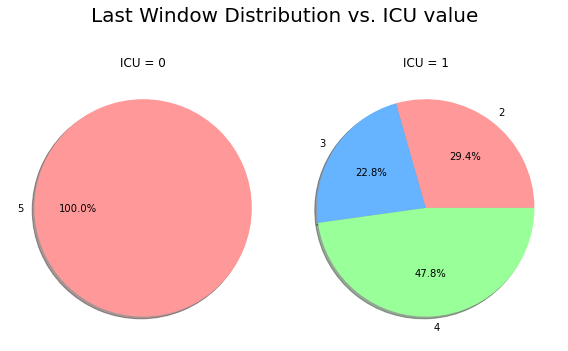

In [32]:
#Plot last window distribution according to target value
fig, axis = plt.subplots(1,2, figsize = (8, 10))
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

for target in data_2['ICU'].unique():
    target_indices = data_2[data_2['ICU'] == target].index
    labels, sizes = np.unique([x[1] for x in last_window if x[0] in target_indices], return_counts = True)
    axis[target].pie(sizes, labels = labels, 
                     shadow = True, 
                     colors = colors,
                     autopct = '%1.1f%%')
    axis[target].set_title('ICU = %d' %target)

fig.tight_layout(rect = [0, 0.4, 1, 1])
plt.suptitle('Last Window Distribution vs. ICU value', fontsize = 20)
plt.show()

From the pattern highlighed in the graph above, there is the reasonable concern a correlation might exist between the features distribution and the time window in which they were taken. The data exploration performed in [our previous notebook](https://www.kaggle.com/epdrumond/icu-admission-data-cleaning-and-exploration) only supports this assumption. It is then wise to look further into this matter and verify whether or not this is true. This is important because, in real life situations, our model could undervalue the likelyhood of a patient going to the ICU solely on the basis of how much he or she has already spent in the hospital.

In [33]:
#Add last window information to dataset
data_2 = data_2.join(
    other = pd.DataFrame(data = last_window, columns = ['INDEX', 'LAST_WINDOW']).set_index('INDEX'),
    how = 'inner')

Text(0.5, 1.0, 'Distribution of Pearson correlation coefficient with respect to LAST_WINDOW')

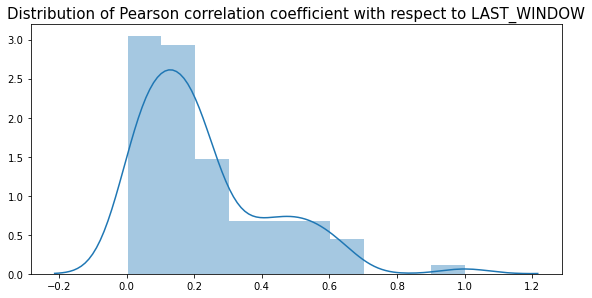

In [34]:
#Define feature groups to investigate and compute pearson correlation
cols_to_investigate = np.unique([x for x in data_2.columns if x.split('_')[-1] in ('end', 'begin')])

data_2_corr = data_2[np.append(cols_to_investigate, 'LAST_WINDOW')].corr()['LAST_WINDOW']
data_2_corr = abs(data_2_corr)

plt.figure(figsize = (8,4))
sns.distplot(data_2_corr.values)
plt.tight_layout()
plt.title('Distribution of Pearson correlation coefficient with respect to LAST_WINDOW', fontsize = 15)

As we can see, most features are poorly correlated to LAST_WINDOW. Still a couple of them present correlation coeficient values higher than 0.5. Let's take a look at those.

In [35]:
#Select strongly LAST_WINDOW correlated features
data_2_corr = data_2_corr[(data_2_corr >= 0.5) & (data_2_corr < 1)]
data_2_corr.sort_values(ascending = False)

TEMPERATURE_DIFF_REL_end                0.632362
TEMPERATURE_DIFF_end                    0.629489
HEART_RATE_DIFF_REL_end                 0.626857
HEART_RATE_DIFF_end                     0.613473
BLOODPRESSURE_DIASTOLIC_DIFF_end        0.561317
RESPIRATORY_RATE_MIN_end                0.552837
TEMPERATURE_MIN_end                     0.538746
BLOODPRESSURE_SISTOLIC_DIFF_REL_end     0.535384
BLOODPRESSURE_SISTOLIC_DIFF_end         0.511842
BLOODPRESSURE_DIASTOLIC_DIFF_REL_end    0.509226
Name: LAST_WINDOW, dtype: float64

Text(0.5, 0.98, 'Investigating TEMPERATURE_DIFF_REL_end and BLOODPRESSURE_DIASTOLIC_DIFF_REL_end correlations')

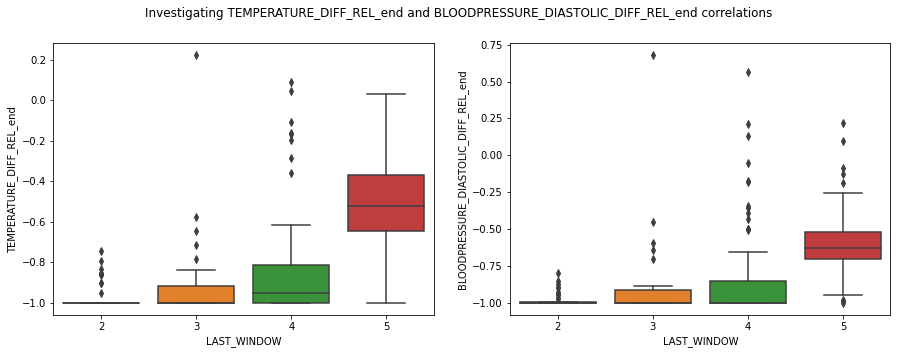

In [36]:
#Plot TEMPERATURE_DIFF_REL_end, the one with the larger correlation coefficient
fig, axis = plt.subplots(1, 2, figsize = (15, 5))

sns.boxplot(x = 'LAST_WINDOW', y = 'TEMPERATURE_DIFF_REL_end', data = data_2, ax = axis[0])
sns.boxplot(x = 'LAST_WINDOW', y = 'BLOODPRESSURE_DIASTOLIC_DIFF_REL_end', data = data_2, ax = axis[1])


plt.suptitle('Investigating TEMPERATURE_DIFF_REL_end and BLOODPRESSURE_DIASTOLIC_DIFF_REL_end correlations')

This first assessment on the relationship between reveals some interesting points. First of all, most of the more strongly correlated features are part of the *DIFF* and *DIFF_REL* feature groups. When ploting two of them, we see the correlation is really onto something. The feature distribution does change a lot according to the window in which the measurement was taken.

As we really want to be on the safe side, we are going to remove all of these features and their counterparts. To be clear, not only *TEMPERATURE_DIFF_REL_end* is being cut off, but also *TEMPERATURE_DIFF_REL_begin*. Later, should the need arise, we can revisit this decision.

In [37]:
#Remove features strongly correlated to LAST_WINDOW
col_groups_to_remove = ['_'.join(x.split('_')[:-1]) for x in data_2_corr.index] 
remaining_cols = [x for x in data_2.columns if '_'.join(x.split('_')[:-1]) not in col_groups_to_remove]

data_2 = data_2[remaining_cols]
data_2.head()

,BLOODPRESSURE_DIASTOLIC_MAX_begin,BLOODPRESSURE_DIASTOLIC_MEAN_begin,BLOODPRESSURE_DIASTOLIC_MEDIAN_begin,BLOODPRESSURE_DIASTOLIC_MIN_begin,BLOODPRESSURE_SISTOLIC_MAX_begin,BLOODPRESSURE_SISTOLIC_MEAN_begin,BLOODPRESSURE_SISTOLIC_MEDIAN_begin,BLOODPRESSURE_SISTOLIC_MIN_begin,DISEASE GROUPING 1_begin,DISEASE GROUPING 2_begin,...,RESPIRATORY_RATE_MEDIAN_end,TEMPERATURE_MAX_end,TEMPERATURE_MEAN_end,TEMPERATURE_MEDIAN_end,AGE_ABOVE65_1,AGE_PERCENTIL_1,GENDER_1,HTN_1,ICU,LAST_WINDOW
14,-0.470085,-0.234568,-0.234568,-0.030928,-0.686486,-0.553846,-0.553846,-0.2625,0.0,0.0,...,-0.103448,-0.362319,-0.214286,-0.214286,1,60th,1,0.0,1,2
18,-0.008547,0.399177,0.382716,0.484536,-0.351351,-0.133333,-0.076923,-0.0125,0.0,0.0,...,-0.034483,-0.043478,0.178571,0.178571,0,20th,0,0.0,1,2
24,-0.589744,-0.407407,-0.407407,-0.175258,-0.664865,-0.523077,-0.523077,-0.2375,0.0,0.0,...,-0.586207,-0.014493,0.214286,0.214286,1,80th,1,0.0,1,2
29,-0.589744,-0.407407,-0.407407,-0.175258,-0.729730,-0.615385,-0.615385,-0.3125,0.0,0.0,...,-0.517241,0.188406,0.464286,0.464286,1,70th,0,1.0,1,2
31,-0.572650,-0.382716,-0.382716,-0.154639,-0.729730,-0.615385,-0.615385,-0.3125,0.0,0.0,...,0.172414,-0.275362,-0.107143,-0.107143,1,90th,0,0.0,1,2


## 4.2. Correlations

Up to this point, our use of correlation scores was focused on managing an specific issue regarding the problem definition. Now we are looking at the relationships between features to see if there is anything we can learn from our dataset.

On the previous modeling we conducted, a similar investigation was performed. However, as we are not necessaraly using window-1 data, it is better to explore this version of the data without any preconceptions. However, we can still learn from our mistakes. So, let's skip plotting another messy heatmap and jump straight to ranking the relationships by their correlation score.

In [38]:
#Rank feature correlations
data_2_corr = rank_correlation_score(data_2)
data_2_corr = data_2_corr[data_2_corr['Pearson_Corr'] < 1]
data_2_corr

,Feature_1,Feature_2,Pearson_Corr
1481,OXYGEN_SATURATION_DIFF_begin,OXYGEN_SATURATION_DIFF_REL_begin,0.999805
3997,OXYGEN_SATURATION_DIFF_end,OXYGEN_SATURATION_DIFF_REL_end,0.999786
1111,HEART_RATE_MEAN_begin,HEART_RATE_MEDIAN_begin,0.993496
371,BLOODPRESSURE_SISTOLIC_MEAN_begin,BLOODPRESSURE_SISTOLIC_MEDIAN_begin,0.993123
4441,RESPIRATORY_RATE_DIFF_end,RESPIRATORY_RATE_DIFF_REL_end,0.987923
...,...,...,...
1528,OXYGEN_SATURATION_DIFF_begin,AGE_ABOVE65_1,0.000237
374,BLOODPRESSURE_SISTOLIC_MEAN_begin,DISEASE GROUPING 2_begin,0.000236
1509,OXYGEN_SATURATION_DIFF_begin,HEART_RATE_MEAN_end,0.000175
1967,RESPIRATORY_RATE_DIFF_begin,GENDER_1,0.000126


Once again, we see some features are extremely correlated. Let's look deeper at these cases.

In [39]:
data_2_corr[data_2_corr['Pearson_Corr'] >= 0.9]

,Feature_1,Feature_2,Pearson_Corr
1481,OXYGEN_SATURATION_DIFF_begin,OXYGEN_SATURATION_DIFF_REL_begin,0.999805
3997,OXYGEN_SATURATION_DIFF_end,OXYGEN_SATURATION_DIFF_REL_end,0.999786
1111,HEART_RATE_MEAN_begin,HEART_RATE_MEDIAN_begin,0.993496
371,BLOODPRESSURE_SISTOLIC_MEAN_begin,BLOODPRESSURE_SISTOLIC_MEDIAN_begin,0.993123
4441,RESPIRATORY_RATE_DIFF_end,RESPIRATORY_RATE_DIFF_REL_end,0.987923
1925,RESPIRATORY_RATE_DIFF_begin,RESPIRATORY_RATE_DIFF_REL_begin,0.987618
2369,TEMPERATURE_MEAN_begin,TEMPERATURE_MEDIAN_begin,0.986740
3627,HEART_RATE_MEAN_end,HEART_RATE_MEDIAN_end,0.986183
75,BLOODPRESSURE_DIASTOLIC_MEAN_begin,BLOODPRESSURE_DIASTOLIC_MEDIAN_begin,0.985853
4074,OXYGEN_SATURATION_DIFF_REL_end,OXYGEN_SATURATION_MIN_end,0.985579


Mostly, these stronger correlations can be grouped in two types:

1. *Begin* features strongly correlated to *End* features for the same measurements (Time relevant correlations).
2. Features correlated at the same time level (Time irrelevant correlations).

Next, we are looking at these two groups and determine whether any feature engineering or selection can be performed there.

### 4.2.1. Time Relevant Correlations

In [40]:
data_2_corr['Feature_1_Type'] = [x.split('_')[-1] for x in data_2_corr['Feature_1']]
data_2_corr['Feature_2_Type'] = [x.split('_')[-1] for x in data_2_corr['Feature_2']]

time_corr = data_2_corr[data_2_corr['Pearson_Corr'] >= 0.9]
time_corr = time_corr[data_2_corr['Feature_1_Type'] != data_2_corr['Feature_2_Type']]

time_corr.drop(columns = ['Feature_1_Type', 'Feature_2_Type'])

,Feature_1,Feature_2,Pearson_Corr
1366,IMMUNOCOMPROMISED_begin,IMMUNOCOMPROMISED_end,0.966490
922,DISEASE GROUPING 5_begin,DISEASE GROUPING 5_end,0.956747
700,DISEASE GROUPING 2_begin,DISEASE GROUPING 2_end,0.933942
774,DISEASE GROUPING 3_begin,DISEASE GROUPING 3_end,0.932946


Looking at the above relationships, all the features in question are actually binary. The Pearson correlation evaluation, in that case, is not even the proper test to be applied. However, these results probably mean the feature value does not change from one time window to the other. Let's take the last feature, *DISEASE GROUPING 3* as an example to see if this is actually true.

In [41]:
print('Percentage of records in which DESEASE GROUPING 3 value does not change: %2.1f%%' \
    %(100*len(data_2[data_2['DISEASE GROUPING 3_begin'] == data_2['DISEASE GROUPING 3_end']]) / len(data_2)))

Percentage of records in which DESEASE GROUPING 3 value does not change: 98.8%


As we can see, even for the least strong correlation value, the attribute remains mostly unchanged for the two time levels in question. This raises an interesting possibility: could we use the variable change as feature? Let's see if the possible new attribute correlates to the target in any level. 

In [42]:
#Define function to compute how the feature change relates to the target
def compute_likelyhood(data, col, target):
    begin_col = col + '_begin'
    end_col = col + '_end'
    
    change_data = data[data[begin_col] != data[end_col]]
    no_change_data = data[data[begin_col] == data[end_col]]
        
    change_likelyhood = len(change_data[change_data[target] == 1]) / len(change_data)
    no_change_likelyhood = len(no_change_data[no_change_data[target] == 1]) / len(no_change_data)
    
    print('Success probability on change: %2.1f%%' %(100 * change_likelyhood))
    print('Success probability on no change: %2.1f%%'%(100 * no_change_likelyhood))

In [43]:
compute_likelyhood(data_2, 'DISEASE GROUPING 3', 'ICU')

Success probability on change: 0.0%
Success probability on no change: 42.4%


The data shows promissing results. There is no record of patient going to the ICU while having it *DISEASE GROUPING 3* value change over time. However, there is one issue that we must consider. For this very small dataset, the 1.2% percent of the records in which this change does occur represent solely 4 patients. You don't have to be an expert to see it is not very smart to make any decisions based on such a small sample size. These occurances, for all we know, could very well be the result of wrong initial assessment of the patient condition or previous diseases.

Given this, our choice will be to remove the *begin* features for the strong correlations we highlighed. Before we do it, though, we should check the other binary features, specially the remaining *DISEASE GROUPINGS*.

In [44]:
data_2['DISEASE GROUPING 3_begin'].unique()

array([0., 1.])

In [45]:
binary_feature_groups = np.unique(['_'.join(x.split('_')[:-1]) for x in data_2.columns.values 
                                   if len(data_2[x].unique()) == 2], return_counts = True)
binary_feature_groups = [x for x,y  in zip(binary_feature_groups[0], binary_feature_groups[1]) if y > 1]

#Selected desired correlations
binary_feat_time_corr = data_2_corr[data_2_corr['Feature_1_Type'] != data_2_corr['Feature_2_Type']]
binary_feat_time_corr['Feature_1_Type'] = ['_'.join(x.split('_')[:-1]) 
                                           for x in binary_feat_time_corr['Feature_1']]
binary_feat_time_corr['Feature_2_Type'] = ['_'.join(x.split('_')[:-1]) 
                                           for x in binary_feat_time_corr['Feature_2']]

binary_feat_time_corr = binary_feat_time_corr[
    binary_feat_time_corr['Feature_1_Type'] == binary_feat_time_corr['Feature_2_Type']]
binary_feat_time_corr = binary_feat_time_corr[binary_feat_time_corr['Feature_1_Type'].isin(binary_feature_groups)]
binary_feat_time_corr

,Feature_1,Feature_2,Pearson_Corr,Feature_1_Type,Feature_2_Type
1366,IMMUNOCOMPROMISED_begin,IMMUNOCOMPROMISED_end,0.966490,IMMUNOCOMPROMISED,IMMUNOCOMPROMISED
922,DISEASE GROUPING 5_begin,DISEASE GROUPING 5_end,0.956747,DISEASE GROUPING 5,DISEASE GROUPING 5
700,DISEASE GROUPING 2_begin,DISEASE GROUPING 2_end,0.933942,DISEASE GROUPING 2,DISEASE GROUPING 2
774,DISEASE GROUPING 3_begin,DISEASE GROUPING 3_end,0.932946,DISEASE GROUPING 3,DISEASE GROUPING 3
996,DISEASE GROUPING 6_begin,DISEASE GROUPING 6_end,0.882772,DISEASE GROUPING 6,DISEASE GROUPING 6
626,DISEASE GROUPING 1_begin,DISEASE GROUPING 1_end,0.863576,DISEASE GROUPING 1,DISEASE GROUPING 1
1440,OTHER_begin,OTHER_end,0.323649,OTHER,OTHER


Besides the four previous correlations, there another three of the time variant type involving binary features. The last one, for the *OTHER* feature, is not relevant in this context, since its value is much smaller compared to the other ones. This leaves us with two extra relationship, both of which present very large correlation scores. We can adopt the procedure mentioned above: consider the *end* feature as the correct assessment and remove the *begin* feature.

In [46]:
#Remove '_begin' features for strongly time correlated group of attributes
data_2 = data_2.drop(columns = 
                     binary_feat_time_corr[binary_feat_time_corr['Feature_1'] != 'OTHER_begin']['Feature_1'])
data_2.head()

,BLOODPRESSURE_DIASTOLIC_MAX_begin,BLOODPRESSURE_DIASTOLIC_MEAN_begin,BLOODPRESSURE_DIASTOLIC_MEDIAN_begin,BLOODPRESSURE_DIASTOLIC_MIN_begin,BLOODPRESSURE_SISTOLIC_MAX_begin,BLOODPRESSURE_SISTOLIC_MEAN_begin,BLOODPRESSURE_SISTOLIC_MEDIAN_begin,BLOODPRESSURE_SISTOLIC_MIN_begin,DISEASE GROUPING 4_begin,HEART_RATE_MAX_begin,...,RESPIRATORY_RATE_MEDIAN_end,TEMPERATURE_MAX_end,TEMPERATURE_MEAN_end,TEMPERATURE_MEDIAN_end,AGE_ABOVE65_1,AGE_PERCENTIL_1,GENDER_1,HTN_1,ICU,LAST_WINDOW
14,-0.470085,-0.234568,-0.234568,-0.030928,-0.686486,-0.553846,-0.553846,-0.2625,0.0,-0.716418,...,-0.103448,-0.362319,-0.214286,-0.214286,1,60th,1,0.0,1,2
18,-0.008547,0.399177,0.382716,0.484536,-0.351351,-0.133333,-0.076923,-0.0125,0.0,-0.253731,...,-0.034483,-0.043478,0.178571,0.178571,0,20th,0,0.0,1,2
24,-0.589744,-0.407407,-0.407407,-0.175258,-0.664865,-0.523077,-0.523077,-0.2375,0.0,-0.492537,...,-0.586207,-0.014493,0.214286,0.214286,1,80th,1,0.0,1,2
29,-0.589744,-0.407407,-0.407407,-0.175258,-0.729730,-0.615385,-0.615385,-0.3125,1.0,-0.731343,...,-0.517241,0.188406,0.464286,0.464286,1,70th,0,1.0,1,2
31,-0.572650,-0.382716,-0.382716,-0.154639,-0.729730,-0.615385,-0.615385,-0.3125,0.0,-0.313433,...,0.172414,-0.275362,-0.107143,-0.107143,1,90th,0,0.0,1,2


### 4.2.2. Time Irrelevant Correlations

In [47]:
#Select correlations for features in the same time level
single_time_step_corr = data_2_corr[data_2_corr['Feature_1_Type'] == data_2_corr['Feature_2_Type']]
single_time_step_corr = single_time_step_corr[single_time_step_corr['Pearson_Corr'] >= 0.9]
single_time_step_corr

,Feature_1,Feature_2,Pearson_Corr,Feature_1_Type,Feature_2_Type
1481,OXYGEN_SATURATION_DIFF_begin,OXYGEN_SATURATION_DIFF_REL_begin,0.999805,begin,begin
3997,OXYGEN_SATURATION_DIFF_end,OXYGEN_SATURATION_DIFF_REL_end,0.999786,end,end
1111,HEART_RATE_MEAN_begin,HEART_RATE_MEDIAN_begin,0.993496,begin,begin
371,BLOODPRESSURE_SISTOLIC_MEAN_begin,BLOODPRESSURE_SISTOLIC_MEDIAN_begin,0.993123,begin,begin
4441,RESPIRATORY_RATE_DIFF_end,RESPIRATORY_RATE_DIFF_REL_end,0.987923,end,end
1925,RESPIRATORY_RATE_DIFF_begin,RESPIRATORY_RATE_DIFF_REL_begin,0.987618,begin,begin
2369,TEMPERATURE_MEAN_begin,TEMPERATURE_MEDIAN_begin,0.986740,begin,begin
3627,HEART_RATE_MEAN_end,HEART_RATE_MEDIAN_end,0.986183,end,end
75,BLOODPRESSURE_DIASTOLIC_MEAN_begin,BLOODPRESSURE_DIASTOLIC_MEDIAN_begin,0.985853,begin,begin
4074,OXYGEN_SATURATION_DIFF_REL_end,OXYGEN_SATURATION_MIN_end,0.985579,end,end


Looking at all the selected correlation for which the time step as the same for both features, we observe the pattern is similar to when we were doing this same procedure on the previous model. Most strong correlation are of the *MEAN/MEDIAN* type, followed by some *DIFF/DIFF_REL* and a few *DIFF/MIN*. Before we decide on what do, let's how one of these correlations looks on a plot.

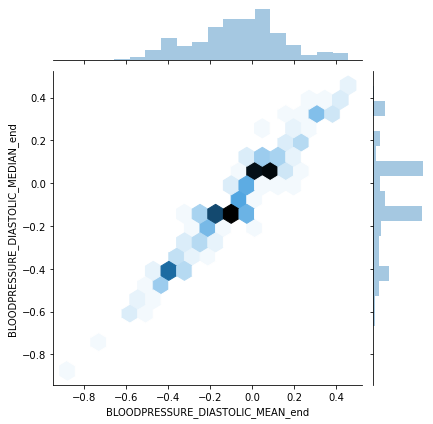

In [48]:
#Plot BLOODPRESSURE_DIASTOLIC_MEAN_end vs. BLOODPRESSURE_DIASTOLIC_MEDIAN_end
sns.jointplot('BLOODPRESSURE_DIASTOLIC_MEAN_end', 'BLOODPRESSURE_DIASTOLIC_MEDIAN_end', data_2, kind = 'hex')

The graph confirms what the Pearson correlation score indicated. The two features are highly dependent on each other. As we are talking about extremely high correlation values, all of them over 0.97, we can simply remove one feature for each pair. As for any remaining strong correlations we have not investigated, other feature selection procedures will be applied on the dataset, meaning our work on cleaning the data is not done yet.

In [49]:
#Remove correlated features
data_2 = data_2.drop(columns = single_time_step_corr['Feature_2'].values)
data_2.head()

,BLOODPRESSURE_DIASTOLIC_MAX_begin,BLOODPRESSURE_DIASTOLIC_MEAN_begin,BLOODPRESSURE_DIASTOLIC_MIN_begin,BLOODPRESSURE_SISTOLIC_MAX_begin,BLOODPRESSURE_SISTOLIC_MEAN_begin,BLOODPRESSURE_SISTOLIC_MIN_begin,DISEASE GROUPING 4_begin,HEART_RATE_MAX_begin,HEART_RATE_MEAN_begin,HEART_RATE_MIN_begin,...,RESPIRATORY_RATE_MAX_end,RESPIRATORY_RATE_MEAN_end,TEMPERATURE_MAX_end,TEMPERATURE_MEAN_end,AGE_ABOVE65_1,AGE_PERCENTIL_1,GENDER_1,HTN_1,ICU,LAST_WINDOW
14,-0.470085,-0.234568,-0.030928,-0.686486,-0.553846,-0.2625,0.0,-0.716418,-0.641509,-0.487179,...,-0.212121,-0.118644,-0.362319,-0.214286,1,60th,1,0.0,1,2
18,-0.008547,0.399177,0.484536,-0.351351,-0.133333,-0.0125,0.0,-0.253731,-0.295597,-0.282051,...,-0.151515,-0.186441,-0.043478,0.178571,0,20th,0,0.0,1,2
24,-0.589744,-0.407407,-0.175258,-0.664865,-0.523077,-0.2375,0.0,-0.492537,-0.358491,-0.230769,...,-0.636364,-0.593220,-0.014493,0.214286,1,80th,1,0.0,1,2
29,-0.589744,-0.407407,-0.175258,-0.729730,-0.615385,-0.3125,1.0,-0.731343,-0.660377,-0.504274,...,-0.575758,-0.525424,0.188406,0.464286,1,70th,0,1.0,1,2
31,-0.572650,-0.382716,-0.154639,-0.729730,-0.615385,-0.3125,0.0,-0.313433,-0.132075,-0.025641,...,0.030303,0.152542,-0.275362,-0.107143,1,90th,0,0.0,1,2


## 4.3. Baseline Model

We have already removed some of the most obvious case of not so relevant features. Before proceeding to other feature selection techniques, let's train a model to serve as our baseline for the next optimization steps. As we have obtained some good results using a Random Forest Classifier, we are going to stick to it for now.

In [50]:
#Encode remaining categorical feature
data_2 = encode_feature(data_2, 'AGE_PERCENTIL_1')

In [51]:
#Split dataset into training and validation
feature_cols = data_2.drop(columns = ['ICU', 'LAST_WINDOW']).columns
x_train, x_validation, y_train, y_validation = train_test_split(data_2[feature_cols], data_2['ICU'],
                                                                test_size = 0.1,
                                                                shuffle = True)

In [52]:
#Cross-validate baseline model
baseline_model = RandomForestClassifier()
fitted_baseline_model = score_model(estimator = baseline_model, 
                                    train_data = (x_train, y_train),
                                    validation_data = (x_validation, y_validation), 
                                    cv = 5)

CV model accuracy:  0.949 +/- 0.019
CV model roc_auc:  0.982 +/- 0.015
Validation accuracy score: 0.879
Validation ROC_AUC score: 0.882


In [53]:
#Plot confusion matrix for validation data
confusion_matrix(y_validation, fitted_baseline_model.predict(x_validation))

array([[21,  3],
       [ 1,  8]])

The results are surprisingly accurate for our first try. Honestly, almost to good to be true. Let's double check.

In [54]:
#Compute baseline model score for a different random seed
np.random.seed(100)

x_train, x_validation, y_train, y_validation = train_test_split(data_2[feature_cols], data_2['ICU'],
                                                                test_size = 0.1,
                                                                shuffle = True)

fitted_baseline_model_2 = score_model(estimator = RandomForestClassifier(), 
                                    train_data = (x_train, y_train),
                                    validation_data = (x_validation, y_validation), 
                                    cv = 5)

CV model accuracy:  0.945 +/- 0.013
CV model roc_auc:  0.981 +/- 0.017
Validation accuracy score: 0.970
Validation ROC_AUC score: 0.975


In [55]:
#Compute score for a KNN model
fitted_baseline_model_3 = score_model(estimator = KNN(), 
                                    train_data = (x_train, y_train),
                                    validation_data = (x_validation, y_validation), 
                                    cv = 5)

CV model accuracy:  0.740 +/- 0.040
CV model roc_auc:  0.837 +/- 0.034
Validation accuracy score: 0.697
Validation ROC_AUC score: 0.629


It looks like this is not a mistake. If we look at the accuracy score for the KNN model, it is clear, we are not just getting the same results regardless of the choice of algorithm. It seems all the work we had processing the data was actually worth the trouble.

But this is not the time to get overly excited. Let's explore our model further.

# 4.4. Feature Selection

Let's first look at our baseline model and find out which features were more relevant to the final result.

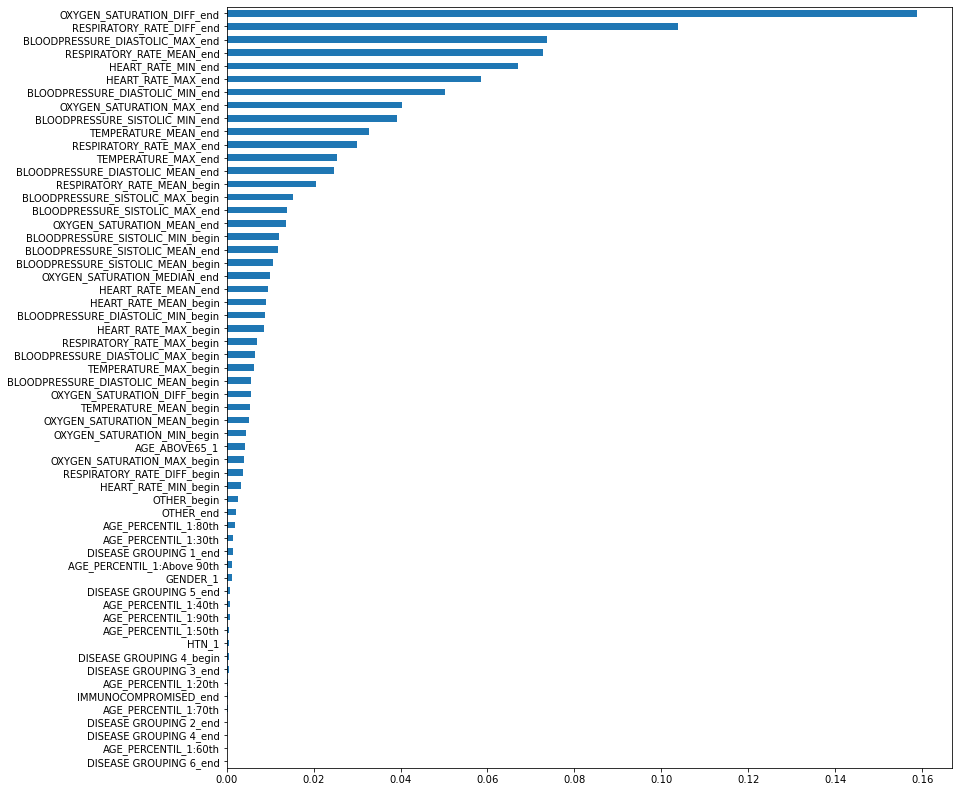

In [56]:
#Plot feature importances for the Random Forest Model
feat_importances = pd.Series(data = fitted_baseline_model.feature_importances_,
                             index = feature_cols).sort_values()
feat_importances.plot(kind = 'barh', figsize = (13, 14))

Here, we have that some present nearly no importance to the model. These can be easily removed from our model. However, just to be safe, let's see if the model actually does not miss them.

In [57]:
#Remove the 30% least important features
threhshold_index = int(len(feat_importances) * 0.7)
reduced_feature_cols = feat_importances.sort_values(ascending = False).index.values[:threhshold_index]

score_model(estimator = RandomForestClassifier(), 
            train_data = (x_train[reduced_feature_cols], y_train),
            validation_data = (x_validation[reduced_feature_cols], y_validation), 
            cv = 5)

CV model accuracy:  0.938 +/- 0.023
CV model roc_auc:  0.983 +/- 0.017
Validation accuracy score: 0.970
Validation ROC_AUC score: 0.975


RandomForestClassifier()

There is no perceptible change on the accuracy and ROC_AUC scores. We can then assume removing these features will not hurt our predictive model.

In [58]:
#Remove least important features
not_important_cols = [x for x in feature_cols if x not in reduced_feature_cols]
data_2 = data_2.drop(columns = not_important_cols)
data_2.head()

,BLOODPRESSURE_DIASTOLIC_MAX_begin,BLOODPRESSURE_DIASTOLIC_MEAN_begin,BLOODPRESSURE_DIASTOLIC_MIN_begin,BLOODPRESSURE_SISTOLIC_MAX_begin,BLOODPRESSURE_SISTOLIC_MEAN_begin,BLOODPRESSURE_SISTOLIC_MIN_begin,HEART_RATE_MAX_begin,HEART_RATE_MEAN_begin,HEART_RATE_MIN_begin,OTHER_begin,...,OXYGEN_SATURATION_MEDIAN_end,RESPIRATORY_RATE_DIFF_end,RESPIRATORY_RATE_MAX_end,RESPIRATORY_RATE_MEAN_end,TEMPERATURE_MAX_end,TEMPERATURE_MEAN_end,AGE_ABOVE65_1,ICU,LAST_WINDOW,AGE_PERCENTIL_1:80th
14,-0.470085,-0.234568,-0.030928,-0.686486,-0.553846,-0.2625,-0.716418,-0.641509,-0.487179,1.0,...,0.736842,-1.000000,-0.212121,-0.118644,-0.362319,-0.214286,1,1,2,0
18,-0.008547,0.399177,0.484536,-0.351351,-0.133333,-0.0125,-0.253731,-0.295597,-0.282051,0.0,...,0.842105,-0.647059,-0.151515,-0.186441,-0.043478,0.178571,0,1,2,0
24,-0.589744,-0.407407,-0.175258,-0.664865,-0.523077,-0.2375,-0.492537,-0.358491,-0.230769,1.0,...,0.684211,-1.000000,-0.636364,-0.593220,-0.014493,0.214286,1,1,2,1
29,-0.589744,-0.407407,-0.175258,-0.729730,-0.615385,-0.3125,-0.731343,-0.660377,-0.504274,1.0,...,0.736842,-1.000000,-0.575758,-0.525424,0.188406,0.464286,1,1,2,0
31,-0.572650,-0.382716,-0.154639,-0.729730,-0.615385,-0.3125,-0.313433,-0.132075,-0.025641,1.0,...,0.842105,-1.000000,0.030303,0.152542,-0.275362,-0.107143,1,1,2,0


In [59]:
#Retrain model for reduced dataset
feature_cols = [x for x in feature_cols if x in data_2.columns.values]

x_train, x_validation, y_train, y_validation = train_test_split(data_2[feature_cols], data_2['ICU'],
                                                                test_size = 0.1,
                                                                shuffle = True)

model_2 = score_model(estimator = RandomForestClassifier(), 
                      train_data = (x_train, y_train),
                      validation_data = (x_validation, y_validation), 
                      cv = 5)

CV model accuracy:  0.928 +/- 0.029
CV model roc_auc:  0.976 +/- 0.011
Validation accuracy score: 0.970
Validation ROC_AUC score: 0.971


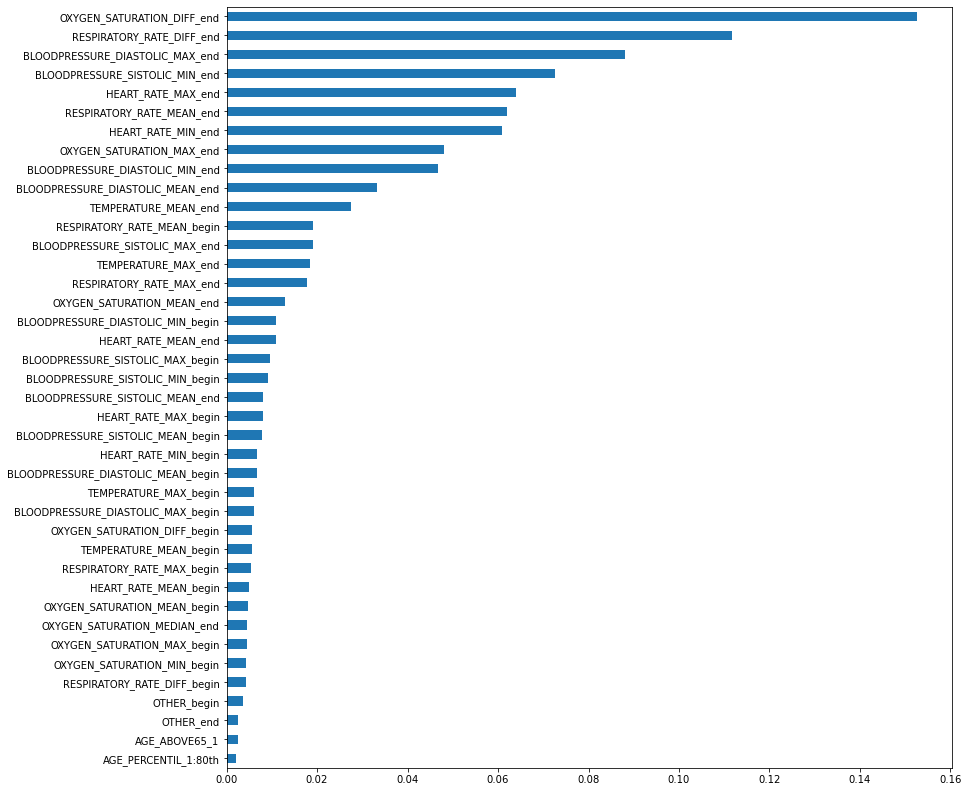

In [60]:
#Re-evaluate feature importances
feat_importances = pd.Series(data = model_2.feature_importances_,
                             index = feature_cols).sort_values()
feat_importances.plot(kind = 'barh', figsize = (13, 14))

It is tempting to keep removing the least important features. However, our model is based on a very small dataset. Removing features by labeling them not relevant to the model might be unwise, considering some relationships could arise as more data is included. Given this, we are going to limit ourselves to removing those attributes that did not really seem to add any value do the predictive model.

# 5. Conclusion

On this notebook, we have been able to create two predictive models for the ICU admission classification problem. The first one focused on the first available data for each patient, obtaining a fairly accurate model. The second model took a time series approach and used data from the last two time windows for each patient. The results for this approach were significantly better compared to the first one. For this model, we investigated the window correlation aspect and removed the most evidently dependent attributes. One indication of the success of this data processing step is how well the model was able to classify patients for both target values.

Once again, we must warn that working with a small datasets limits the extent of how certain we can be about our results. Still, we have achieved some promissing results for two fairly interpretable predictive models.

If got to this point of the notebook, my sincere thanks. Please leave a comment and tell me where I got it wrong and how I can improve.